#### PCA对手写数字数据集的降维
还记得我们上一周在讲特征工程时，使用的手写数字的数据集吗？数据集结构为(42000, 784)，用KNN跑一次半小
时，得到准确率在96.6%上下，用随机森林跑一次12秒，准确率在93.8%，虽然KNN效果好，但由于数据量太大，
KNN计算太缓慢，所以我们不得不选用随机森林。我们使用了各种技术对手写数据集进行特征选择，最后使用嵌入
法SelectFromModel选出了324个特征，将随机森林的效果也调到了96%以上。但是，因为数据量依然巨大，还是
有300多个特征。今天，我们就来试着用PCA处理一下这个数据

In [2]:
# 导入需要的模块和库
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [7]:
data = pd.read_csv(r"./data/digit recognizor.csv") 
X = data.iloc[:,1:]
y = data.iloc[:,0] 
X.shape

(42000, 784)

#### 画累计方差贡献率曲线，找最佳降维后维度的范围

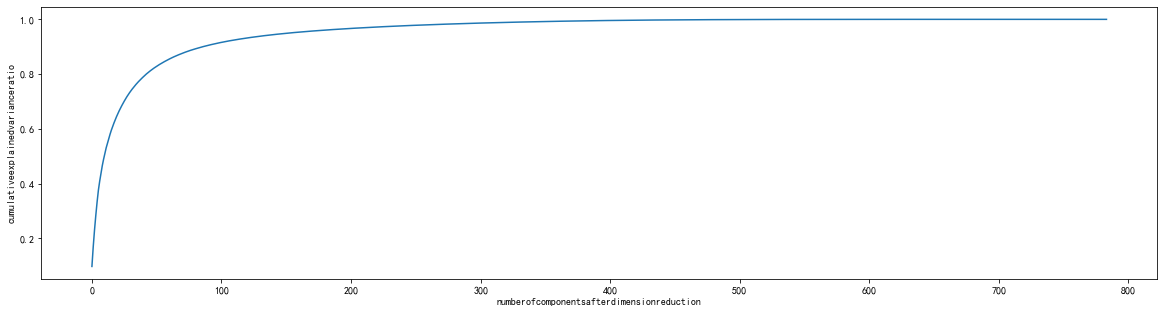

In [9]:
pca_line=PCA().fit(X)
plt.figure(figsize=[20,5])
plt.plot(np.cumsum(pca_line.explained_variance_ratio_))
plt.xlabel("numberofcomponentsafterdimensionreduction")
plt.ylabel("cumulativeexplainedvarianceratio")
plt.show()

#### 降维后维度的学习曲线，继续缩小最佳维度的范围

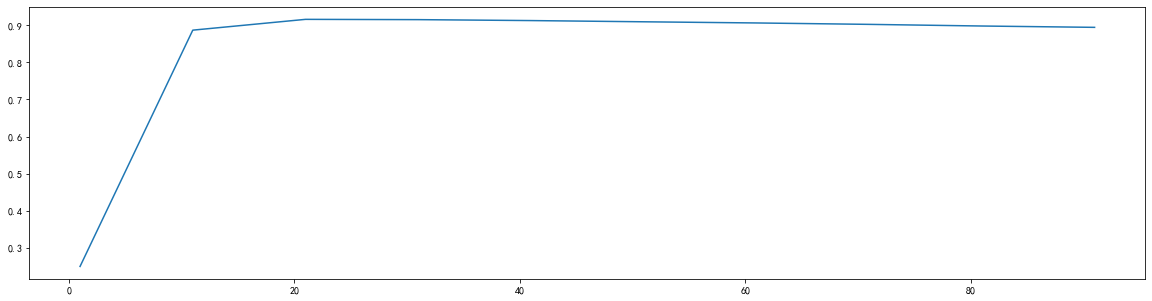

In [15]:
score=[]
for i in range(1,101,10):
    # 以不同降维列数对数据进行降维
    X_dr=PCA(i).fit_transform(X)
    # n_estimators颗树 交叉验证5折 降维后的新矩阵做交叉验证求分数
    once=cross_val_score(RFC(n_estimators=10,random_state=0),X_dr,y,cv=5).mean()
    score.append(once)
plt.figure(figsize=[20,5])
plt.plot(range(1,101,10),score)
plt.show()

#### 细化学习曲线，找出降维后的最佳维度

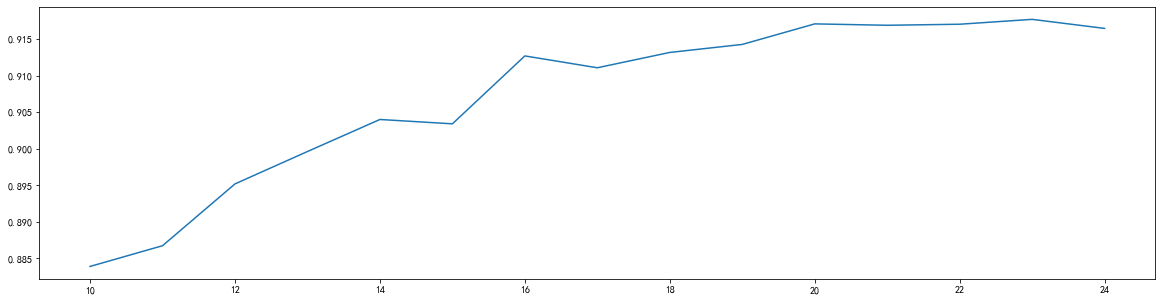

In [20]:
score=[]
for i in range(10,25):
    X_dr=PCA(i).fit_transform(X)
    once=cross_val_score(RFC(n_estimators=10,random_state=0)
                         ,X_dr
                         ,y
                         ,cv=5).mean()
    score.append(once)
plt.figure(figsize=[20,5])
plt.plot(range(10,25),score)
plt.show()

#### 导入找出的最佳维度进行降维，查看模型效果

In [21]:
X_dr=PCA(23).fit_transform(X)
#======【TIMEWARNING:1mins30s】======#
cross_val_score(RFC(n_estimators=100,random_state=0),X_dr,y,cv=5).mean()

0.946

模型效果还好，跑出了94.49%的水平，但还是没有我们使用嵌入法特征选择过后的96%高，有没有什么办法能够提高模型的表现呢？

在之前的建模过程中，因为计算量太大，所以我们一直使用随机森林，但事实上，我们知道KNN的效果比随机森林更好，KNN在未调参的状况下已经达到96%的准确率，而随机森林在未调参前只能达到93%，这是模型本身的限制带来的，这个数据使用KNN效果就是会更好。现在我们的特征数量已经降到不足原来的3%，可以使用KNN了吗？

In [23]:
from sklearn.neighbors import KNeighborsClassifier as KNN
cross_val_score(KNN(),X_dr,y,cv=5).mean()

0.9697619047619048

#### KNN的k值学习曲线

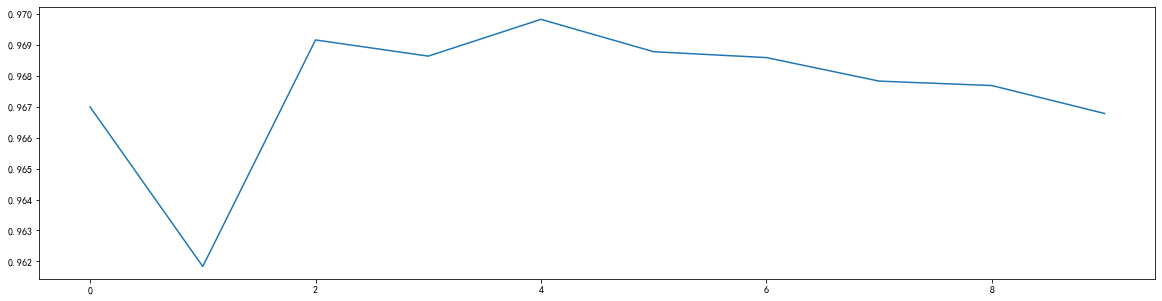

In [25]:
score=[]
X_dr=PCA(23).fit_transform(X)
for i in range(10):
    once=cross_val_score(KNN(i+1),X_dr,y,cv=5).mean()
    score.append(once)
plt.figure(figsize=[20,5])
plt.plot(range(10),score)
plt.show()

### 定下超参数后，模型效果如何，模型运行时间如何？

In [26]:
cross_val_score(KNN(4),X_dr,y,cv=5).mean()
%%timeit 
cross_val_score(KNN(4),X_dr,y,cv=5).mean()

UsageError: Line magic function `%%timeit` not found.


可以发现，原本785列的特征被我们缩减到23列之后，用KNN跑出了目前位置这个数据集上最好的结果。再进行更细致的调整，我们也许可以将KNN的效果调整到98%以上。PCA为我们提供了无限的可能，终于不用再因为数据量太庞大而被迫选择更加复杂的模型了！